In [21]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [22]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 유저 수와 영화 아이템 수

In [23]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


- Time -> date로 바꾸기

In [25]:
from datetime import datetime

data['date']= pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time,date
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


- Session length

In [26]:
session_length = data.groupby('UserId').size()
session_length # 유저 아이디가 서로 같은 것이 몇 개의 영화를 선택했는지

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [27]:
print(session_length.median(), session_length.mean())
print(session_length.min(), session_length.max())
print(session_length.quantile(0.999))

96.0 165.5975165562914
20 2314
1343.181000000005


    - 보통 세션(유저)가 선택한 영화의 개수는 96이 중간값, 평균이 165 정도 됨.
    - 최소로 영화 선택한 개수는 20, 많은 것은 2314개
    - 99.9% 유저의 길이는 1343정도 개

In [28]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time,date
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697219,4169,2653,4,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
...,...,...,...,...,...
697882,4169,3754,2,1024174347,2002-06-15 20:52:27
695702,4169,1413,3,1024175031,2002-06-15 21:03:51
697358,4169,494,4,1024175760,2002-06-15 21:16:00
695945,4169,1804,2,1024175783,2002-06-15 21:16:23


    - 2년 동안 4169라는 유저가 영화를 총 2314개 선택했다.
    - 동일한 시간에 영화를 선택한 것이 이상하다.

- 유저의 길이 시각화

In [29]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

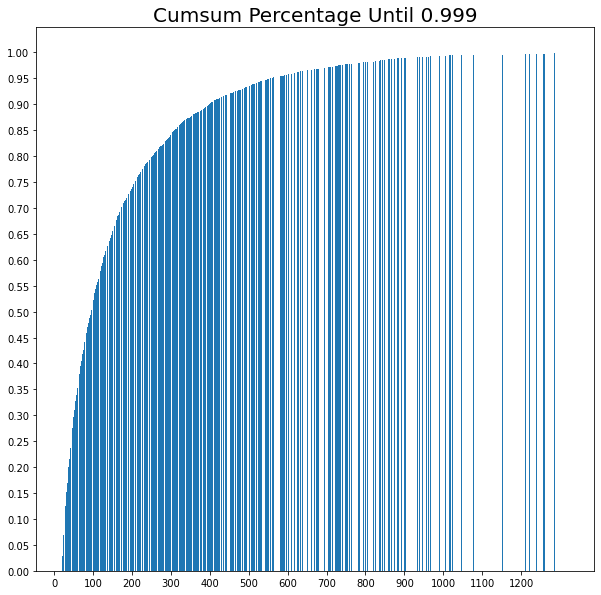

In [30]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10, 10))
plt.bar(length_percent_cumsum_999.index, length_percent_cumsum_999)
ax.tick_params(axis='x', labelsize=16)
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.xticks(np.arange(0, 1300, 100), fontsize =10)
plt.yticks(np.arange(0, 1.01, 0.05))

plt.show()

- session time

In [31]:
oldest, latest = data['date'].min(), data['date'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [32]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [33]:
# 영화에는 날짜를 구분해서 지을 필요가 없다고 생각해서 3년치를 모두 사용

#month_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 365일 이전 날짜를 구한다.  
#data = data[data['date'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
#data

In [34]:
data['date']=pd.to_datetime(data['date'])
data['SessionId']=data.groupby(['UserId',pd.Grouper(key='date',freq='2H')],sort=False).ngroup()

In [35]:
data

,UserId,ItemId,Rating,Time,date,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,0
27,1,1721,4,978300055,2000-12-31 22:00:55,0
37,1,1022,5,978300055,2000-12-31 22:00:55,0
24,1,2340,3,978300103,2000-12-31 22:01:43,0
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,28021
999988,6040,1921,4,997454464,2001-08-10 14:41:04,28021
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,28021
1000167,6040,161,3,997454486,2001-08-10 14:41:26,28021


In [36]:
# Timestamp diff 구하기
#diff_timestamp = data.groupby('UserId')['Time'].diff()

# diff 구한 것이 1분 이상 지나면 새로운 session부여
#new_session = (diff_timestamp.isnull()) | (diff_timestamp > 60)

# 모든 UserId 마다 unique session_id 만들기
#data['SessionId'] = data.loc[new_session, ['UserId', 'Time']] \
#    .groupby('UserId').rank(method='first').astype(int)

# NaN 값인 것을 대체, 인덱스 상에 앞(ffill) 데이터를 가져옴 
#data['SessionId'] = data['SessionId'].fillna(method='ffill').astype(int)

In [38]:
data['SessionId'].unique() # userid 6040명이 하루를 기준으로 다른 날에 본 session Id이다.

array([    0,     1,     2, ..., 28020, 28021, 28022])

In [39]:
data[data['UserId']==3841]

,UserId,ItemId,Rating,Time,date,SessionId
637651,3841,3022,4,965915931,2000-08-10 13:58:51,18349
637975,3841,260,5,965915931,2000-08-10 13:58:51,18349
638393,3841,3504,5,965915931,2000-08-10 13:58:51,18349
638035,3841,445,2,965915968,2000-08-10 13:59:28,18349
638218,3841,838,1,965915968,2000-08-10 13:59:28,18349
...,...,...,...,...,...,...
638297,3841,2502,2,966085874,2000-08-12 13:11:14,18353
638478,3841,2598,3,966085893,2000-08-12 13:11:33,18353
638227,3841,1513,2,966085922,2000-08-12 13:12:02,18353
638370,3841,2395,4,966085922,2000-08-12 13:12:02,18353


In [40]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(28023, 3706)

In [41]:
session_length = data.groupby('SessionId').size()
session_length # 세션 아이디가 서로 같은 것이 몇 개의 제품을 클릭했는지

SessionId
0         40
1         13
2        109
3         20
4         51
        ... 
28018     13
28019      1
28020      1
28021     21
28022      1
Length: 28023, dtype: int64

In [42]:
session_length.median(), session_length.mean()

(7.0, 35.692431217214434)

In [43]:
session_length.min(), session_length.max()

(1, 992)

In [44]:
session_length.quantile(0.999)

537.9780000000028

In [45]:
long_session = session_length[session_length==992].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,date,SessionId
137631,889,1266,3,975247862,2000-11-26 14:11:02,4033
137864,889,2430,3,975247862,2000-11-26 14:11:02,4033
137889,889,1643,3,975247862,2000-11-26 14:11:02,4033
138039,889,3461,3,975247862,2000-11-26 14:11:02,4033
138316,889,1193,1,975247862,2000-11-26 14:11:02,4033
...,...,...,...,...,...,...
138361,889,1502,1,975254382,2000-11-26 15:59:42,4033
138438,889,1541,1,975254382,2000-11-26 15:59:42,4033
138453,889,1550,2,975254382,2000-11-26 15:59:42,4033
138527,889,2385,2,975254382,2000-11-26 15:59:42,4033


    - SessionId 가 긴 사람은 889 이다.

- sessionId 시각화

In [46]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.252293
2      0.348250
3      0.397209
4      0.430361
5      0.459551
         ...   
525    0.998787
528    0.998822
532    0.998858
536    0.998894
537    0.998965
Length: 443, dtype: float64

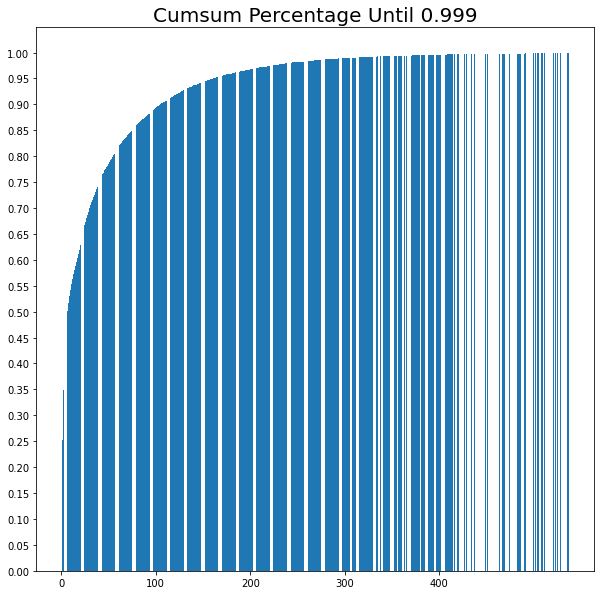

In [47]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(10, 10))
plt.bar(length_percent_cumsum_999.index, length_percent_cumsum_999)
ax.tick_params(axis='x', labelsize=16)
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.xticks(np.arange(0, 500, 100), fontsize =10)
plt.yticks(np.arange(0, 1.01, 0.05))

plt.show()

- 유저가 최소 1 번 이상 클릭 했을 때 예측 하므로 세션 id의 길이가 1인거는 삭제
- 영화 평점이 1-2 점대은 삭제하고 그 후 rate 행을 지웁니다.
- 영화의 클릭 횟수가 3회 이하인것 삭제 합니다.

In [48]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click, rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        data = cleanse_rate_item(data, rating)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data
def cleanse_rate_item(data: pd.DataFrame, rating):
    data = data.drop(data[data['Rating'] < rating].index)
    return data

In [49]:
data = cleanse_recursive(data, shortest=2, least_click=3, rating=3)
data

,UserId,ItemId,Rating,Time,date,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,0
27,1,1721,4,978300055,2000-12-31 22:00:55,0
37,1,1022,5,978300055,2000-12-31 22:00:55,0
24,1,2340,3,978300103,2000-12-31 22:01:43,0
...,...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58,28021
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,28021
999988,6040,1921,4,997454464,2001-08-10 14:41:04,28021
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,28021


- 모델 split

In [50]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['date'].max()
    session_last_time = data.groupby('SessionId')['date'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

- 일년 단위로 짜름.

In [51]:
tr, test = split_by_date(data, n_days=365)
tr, val = split_by_date(tr, n_days=365)

In [52]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["date"].min()}\n'
          f'\t Last Time : {data["date"].max()}\n')

In [53]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 776558
	 Sessions: 15596
	 Items: 3408
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-02-28 08:03:58

* valid Set Stats Info
	 Events: 36861
	 Sessions: 2917
	 Items: 2961
	 First Time : 2001-02-28 14:01:20
	 Last Time : 2002-02-28 13:47:54

* test Set Stats Info
	 Events: 15847
	 Sessions: 1496
	 Items: 2583
	 First Time : 2002-02-28 19:06:39
	 Last Time : 2003-02-28 17:49:50



In [54]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [55]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## session dataset

In [56]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [57]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,date,SessionId,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0,0
22,1,1270,5,978300055,2000-12-31 22:00:55,0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0,2
37,1,1022,5,978300055,2000-12-31 22:00:55,0,3
24,1,2340,3,978300103,2000-12-31 22:01:43,0,4
36,1,1836,5,978300172,2000-12-31 22:02:52,0,5
3,1,3408,4,978300275,2000-12-31 22:04:35,0,6
7,1,2804,5,978300719,2000-12-31 22:11:59,0,7
47,1,1207,4,978300719,2000-12-31 22:11:59,0,8
0,1,1193,5,978300760,2000-12-31 22:12:40,0,9


In [58]:
tr_dataset.click_offsets

array([     0,     40,     53, ..., 776539, 776546, 776558], dtype=int32)

In [59]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 15593, 15594, 15595])

- Session Data Loader

In [60]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [61]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=32)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,date,SessionId,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0,0
22,1,1270,5,978300055,2000-12-31 22:00:55,0,1
27,1,1721,4,978300055,2000-12-31 22:00:55,0,2
37,1,1022,5,978300055,2000-12-31 22:00:55,0,3
24,1,2340,3,978300103,2000-12-31 22:01:43,0,4
36,1,1836,5,978300172,2000-12-31 22:02:52,0,5
3,1,3408,4,978300275,2000-12-31 22:04:35,0,6
7,1,2804,5,978300719,2000-12-31 22:11:59,0,7
47,1,1207,4,978300719,2000-12-31 22:11:59,0,8
0,1,1193,5,978300760,2000-12-31 22:12:40,0,9


In [62]:
iter_ex = iter(tr_data_loader)

In [63]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":6} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  40  53 145  64  54 201 210 325   1  54 458 370 191  72 702 714 718
  53 728 185 751 753  37 782 789   9 406 845 855 672  67]
Label Item Idx are :        [  1  41  54 146  62  24  12 211 135 127 381  15 492 572 664 703 715 719
 536 385  97 752 754 171 783  53  64 832 528   9 642  41]
Previous Masked Input Idx are []


## model

- Evaluation Metric

In [64]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [66]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [86]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [87]:
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 3408)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 100), (32, 100)]    1053000   
_________________________________________________________________
dropout_3 (Dropout)          (32, 100)                 0         
_________________________________________________________________
dense_3 (Dense)              (32, 3408)                344208    
Total params: 1,397,208
Trainable params: 1,397,208
Non-trainable params: 0
_________________________________________________________________


In [88]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [89]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

- batch size = 30 변경  
    args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20) 했을 때  

    test데이터에서  Recall@20은 0.156920이 나오고 MRR@20은 0.043551이 됨.

In [269]:
train_model(model, args)

Evaluation:  97%|█████████▋| 1029/1060 [02:55<00:05,  5.85it/s]


	 - Recall@20 epoch 1: 0.179240
	 - MRR@20    epoch 1: 0.045175



Evaluation:  97%|█████████▋| 1029/1060 [02:51<00:05,  6.00it/s]


	 - Recall@20 epoch 2: 0.203292
	 - MRR@20    epoch 2: 0.054671



Evaluation:  97%|█████████▋| 1029/1060 [02:50<00:05,  6.02it/s]

	 - Recall@20 epoch 3: 0.209761
	 - MRR@20    epoch 3: 0.058047



In [270]:
test_model(model, args, test)

Evaluation:  94%|█████████▍| 420/448 [01:10<00:04,  5.98it/s]

	 - Recall@20: 0.156920
	 - MRR@20: 0.043551



---

-   epoch = 10 으로 변경  

    args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20) 했을 때  

    test데이터에서  Recall@20은 0.163021  MRR@20: 0.045291 이 됨.

In [274]:
train_model(model, args)

Evaluation:  97%|█████████▋| 1029/1060 [02:55<00:05,  5.88it/s]


	 - Recall@20 epoch 1: 0.177114
	 - MRR@20    epoch 1: 0.045399



Evaluation:  97%|█████████▋| 1029/1060 [02:58<00:05,  5.75it/s]


	 - Recall@20 epoch 2: 0.202138
	 - MRR@20    epoch 2: 0.054104



Evaluation:  97%|█████████▋| 1029/1060 [02:54<00:05,  5.91it/s]


	 - Recall@20 epoch 3: 0.209943
	 - MRR@20    epoch 3: 0.057971



Evaluation:  97%|█████████▋| 1029/1060 [02:56<00:05,  5.83it/s]


	 - Recall@20 epoch 4: 0.211522
	 - MRR@20    epoch 4: 0.059415



Evaluation:  97%|█████████▋| 1029/1060 [02:55<00:05,  5.86it/s]


	 - Recall@20 epoch 5: 0.212585
	 - MRR@20    epoch 5: 0.060529



Evaluation:  97%|█████████▋| 1029/1060 [02:42<00:04,  6.32it/s]


	 - Recall@20 epoch 6: 0.212403
	 - MRR@20    epoch 6: 0.060715



Evaluation:  97%|█████████▋| 1029/1060 [02:56<00:05,  5.84it/s]


	 - Recall@20 epoch 7: 0.212949
	 - MRR@20    epoch 7: 0.060899



Evaluation:  97%|█████████▋| 1029/1060 [02:54<00:05,  5.90it/s]


	 - Recall@20 epoch 8: 0.211826
	 - MRR@20    epoch 8: 0.060618



Evaluation:  97%|█████████▋| 1029/1060 [02:49<00:05,  6.07it/s]


	 - Recall@20 epoch 9: 0.212889
	 - MRR@20    epoch 9: 0.060519



Evaluation:  97%|█████████▋| 1029/1060 [02:42<00:04,  6.35it/s]

	 - Recall@20 epoch 10: 0.212099
	 - MRR@20    epoch 10: 0.060197



In [275]:
test_model(model, args, test)

Evaluation:  94%|█████████▍| 420/448 [01:07<00:04,  6.25it/s]

	 - Recall@20: 0.163021
	 - MRR@20: 0.045291



---

- batch_size=64 으로 변경

    args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

    test데이터에서 Recall@20은 0.156488 MRR@20: 0.041598 이 됨.

In [70]:
train_model(model, args)

Evaluation:  95%|█████████▍| 502/530 [02:29<00:08,  3.35it/s]


	 - Recall@20 epoch 1: 0.167393
	 - MRR@20    epoch 1: 0.041599



Evaluation:  95%|█████████▍| 502/530 [02:25<00:08,  3.44it/s]


	 - Recall@20 epoch 2: 0.198923
	 - MRR@20    epoch 2: 0.051570



Evaluation:  95%|█████████▍| 502/530 [02:25<00:08,  3.46it/s]

	 - Recall@20 epoch 3: 0.208696
	 - MRR@20    epoch 3: 0.056615



In [74]:
test_model(model, args, test)

Evaluation:  88%|████████▊ | 197/224 [00:57<00:07,  3.44it/s]

	 - Recall@20: 0.156488
	 - MRR@20: 0.041598



-  hsz = 100으로 변경  

    args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20)  
    
    test데이터에서 Recall@20은 0.164499 MRR@20: 0.046472 이 됨.

In [77]:
train_model(model, args)

Evaluation:  95%|█████████▍| 502/530 [02:24<00:08,  3.48it/s]


	 - Recall@20 epoch 1: 0.186224
	 - MRR@20    epoch 1: 0.047336



Evaluation:  95%|█████████▍| 502/530 [02:21<00:07,  3.55it/s]


	 - Recall@20 epoch 2: 0.209008
	 - MRR@20    epoch 2: 0.056948



Evaluation:  95%|█████████▍| 502/530 [02:21<00:07,  3.54it/s]

	 - Recall@20 epoch 3: 0.214455
	 - MRR@20    epoch 3: 0.060192



In [78]:
test_model(model, args, test)

Evaluation:  88%|████████▊ | 197/224 [00:57<00:07,  3.43it/s]

	 - Recall@20: 0.164499
	 - MRR@20: 0.046472



---

-  epochs = 10으로 변경  

    args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)  
    
    test데이터에서 Recall@20은 0.161168 MRR@20: 0.047271 이 됨.

In [83]:
train_model(model, args)

Evaluation:  95%|█████████▍| 502/530 [02:25<00:08,  3.46it/s]


	 - Recall@20 epoch 1: 0.185166
	 - MRR@20    epoch 1: 0.048078



Evaluation:  95%|█████████▍| 502/530 [02:21<00:07,  3.54it/s]


	 - Recall@20 epoch 2: 0.209786
	 - MRR@20    epoch 2: 0.057722



Evaluation:  95%|█████████▍| 502/530 [02:22<00:07,  3.53it/s]


	 - Recall@20 epoch 3: 0.217785
	 - MRR@20    epoch 3: 0.061033



Evaluation:  95%|█████████▍| 502/530 [02:21<00:07,  3.54it/s]


	 - Recall@20 epoch 4: 0.219373
	 - MRR@20    epoch 4: 0.062520



Evaluation:  95%|█████████▍| 502/530 [02:21<00:07,  3.56it/s]


	 - Recall@20 epoch 5: 0.218906
	 - MRR@20    epoch 5: 0.062458



Evaluation:  95%|█████████▍| 502/530 [02:20<00:07,  3.56it/s]


	 - Recall@20 epoch 6: 0.218314
	 - MRR@20    epoch 6: 0.062627



Evaluation:  95%|█████████▍| 502/530 [02:21<00:07,  3.55it/s]


	 - Recall@20 epoch 7: 0.217412
	 - MRR@20    epoch 7: 0.062106



Evaluation:  95%|█████████▍| 502/530 [02:21<00:07,  3.56it/s]


	 - Recall@20 epoch 8: 0.216416
	 - MRR@20    epoch 8: 0.061477



Evaluation:  95%|█████████▍| 502/530 [02:19<00:07,  3.60it/s]


	 - Recall@20 epoch 9: 0.214922
	 - MRR@20    epoch 9: 0.061107



Evaluation:  95%|█████████▍| 502/530 [02:20<00:07,  3.57it/s]

	 - Recall@20 epoch 10: 0.214392
	 - MRR@20    epoch 10: 0.060801



In [84]:
test_model(model, args, test)

Evaluation:  88%|████████▊ | 197/224 [00:57<00:07,  3.44it/s]

	 - Recall@20: 0.161168
	 - MRR@20: 0.047271



---

- epoch = 10 으로 변경

    args = Args(tr, val, test, batch_size=32, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20) 했을 때

    test데이터에서 Recall@20은 0.163021 MRR@20: 0.045291 이 됨.

In [90]:
train_model(model, args)

Evaluation:  97%|█████████▋| 1029/1060 [02:42<00:04,  6.33it/s]


	 - Recall@20 epoch 1: 0.192329
	 - MRR@20    epoch 1: 0.049976



Evaluation:  97%|█████████▋| 1029/1060 [02:40<00:04,  6.42it/s]


	 - Recall@20 epoch 2: 0.210004
	 - MRR@20    epoch 2: 0.057602



Evaluation:  97%|█████████▋| 1029/1060 [02:41<00:04,  6.39it/s]


	 - Recall@20 epoch 3: 0.212190
	 - MRR@20    epoch 3: 0.060077



Evaluation:  97%|█████████▋| 1029/1060 [02:41<00:04,  6.36it/s]


	 - Recall@20 epoch 4: 0.214043
	 - MRR@20    epoch 4: 0.061050



Evaluation:  97%|█████████▋| 1029/1060 [02:39<00:04,  6.44it/s]


	 - Recall@20 epoch 5: 0.212737
	 - MRR@20    epoch 5: 0.060973



Evaluation:  97%|█████████▋| 1029/1060 [02:39<00:04,  6.46it/s]


	 - Recall@20 epoch 6: 0.213587
	 - MRR@20    epoch 6: 0.060700



Evaluation:  97%|█████████▋| 1029/1060 [02:38<00:04,  6.51it/s]


	 - Recall@20 epoch 7: 0.213648
	 - MRR@20    epoch 7: 0.060941



Evaluation:  97%|█████████▋| 1029/1060 [02:39<00:04,  6.47it/s]


	 - Recall@20 epoch 8: 0.212069
	 - MRR@20    epoch 8: 0.060604



Evaluation:  97%|█████████▋| 1029/1060 [02:41<00:04,  6.36it/s]


	 - Recall@20 epoch 9: 0.212555
	 - MRR@20    epoch 9: 0.060458



Evaluation:  97%|█████████▋| 1029/1060 [02:42<00:04,  6.34it/s]

	 - Recall@20 epoch 10: 0.209609
	 - MRR@20    epoch 10: 0.059985



In [91]:
test_model(model, args, test)

Evaluation:  94%|█████████▍| 420/448 [01:07<00:04,  6.22it/s]

	 - Recall@20: 0.162054
	 - MRR@20: 0.045640

